## Churn prediction - Kaggle competition

- Even when a Kaggle competition is over we can still download the data, read notebooks of participants and learn!
<br>And then submit our own prediction to see how well our model perform. 

##### This a an exploratory analysis and prediction with XGBoost for Kaggle competition:

["WSDM - KKBox's Churn Prediction Challenge
Can you predict when subscribers will churn?"](https://www.kaggle.com/c/kkbox-churn-prediction-challenge/)


**Churn definition (in data description on Kaggle)** 
>The criteria of "churn" is no new valid service subscription within 30 days after the current membership expires.

In [1]:
import random
import pandas as pd
import xgboost as xgb
from os.path import join

import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

## Loading the data

The files set provided contains bigger files with data till the end of February 2017 and additional files ("v2" suffix) with update of March 2017.
<br>They are too big to load them all into python but we can concatenate some of them in GNU terminal (Git Bash):
><code>cat transactions.csv > transactions_v3.csv; tail -n +2 transactions_v2.csv >> transactions_v3.csv </code>

In [13]:
PROJECT_DIR = r"C:\Users\Olks\Desktop\churn_prediction"

In [14]:
train_path = join(PROJECT_DIR, "train.csv")
train_v2_path = join(PROJECT_DIR, "train_v2.csv")
user_logs_path = join(PROJECT_DIR, "user_logs.csv")
user_logs_v2_path = join(PROJECT_DIR, "user_logs_v2.csv")
sample_submission_zero_path = join(PROJECT_DIR, "sample_submission_zero.csv")
sample_submission_v2_path = join(PROJECT_DIR, "sample_submission_v2.csv")
transactions_path = join(PROJECT_DIR, "transactions.csv")
transactions_v2_path = join(PROJECT_DIR, "transactions_v2.csv")
transactions_v3_path = join(PROJECT_DIR, "transactions_v3.csv")
members_v3_path = join(PROJECT_DIR, "members_v3.csv")

#### Some files are to big to load them so we will use spark to query them

In [2]:
from pyspark import SparkContext
sc = SparkContext("local", "First App")
print(sc)
print(sc.version)

In [5]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession

# Create my_spark
# getOrCreate() returns an existing if there is one already
my_spark = SparkSession.builder.getOrCreate()

# Print my_spark
print(my_spark)

print(my_spark.catalog.listTables())

In [15]:
file_path = user_logs_path

# Read in the airports data
user_logs = my_spark.read.csv(file_path, header=True)

# Show the data
user_logs.show()

+--------------------+--------+------+------+------+-------+-------+-------+----------+
|                msno|    date|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------+--------+------+------+------+-------+-------+-------+----------+
|rxIP2f2aN0rYNp+to...|20150513|     0|     0|     0|      0|      1|      1|  280.3350|
|rxIP2f2aN0rYNp+to...|20150709|     9|     1|     0|      0|      7|     11| 1658.9480|
|yxiEWwE9VR5utpUec...|20150105|     3|     3|     0|      0|     68|     36|17364.9560|
|yxiEWwE9VR5utpUec...|20150306|     1|     0|     1|      1|     97|     27|24667.3170|
|yxiEWwE9VR5utpUec...|20150501|     3|     0|     0|      0|     38|     38| 9649.0290|
|yxiEWwE9VR5utpUec...|20150702|     4|     0|     1|      1|     33|     10|10021.5200|
|yxiEWwE9VR5utpUec...|20150830|     3|     1|     0|      0|      4|      7| 1119.5550|
|yxiEWwE9VR5utpUec...|20151107|     1|     0|     0|      0|      4|      5|  938.0220|
|yxiEWwE9VR5utpUec...|20160110| 

In [16]:
from pyspark.sql import functions as f

In [ ]:
user_logs.select("date").show()

In [18]:
user_logs.createOrReplaceTempView("user_logs")

In [18]:
# max_date = my_spark.sql("SELECT MAX(date) FROM user_logs")
# max_date.show()

Maximum date in user_logs file: 20170228

In [ ]:
# start: 22:38
# java.lang.OutOfMemoryError
# query = "SELECT msno, MAX(date) FROM user_logs GROUP BY msno"
# last_log = my_spark.sql(query)
# last_log_df = last_log.toPandas()
# last_log_df.to_csv("last_log.csv")
# last_log_df

In [ ]:
# filter only logs from february and save them to csv
query = "SELECT* FROM user_logs WHERE date >= 20170201"
february = my_spark.sql(query)
# df=february.toPandas()
february.show()
february.coalesce(1).write.format('csv').save("february_logs.csv", header='true')

+--------------------+--------+------+------+------+-------+-------+-------+----------+
|                msno|    date|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------+--------+------+------+------+-------+-------+-------+----------+
|mSM/P4XpWcuQUGnhL...|20170225|     0|     0|     1|      0|      5|      6| 1526.6610|
|q3MXOPoaa2SCN4bnP...|20170222|     1|     0|     0|      0|      9|      3| 2326.3920|
|GI65XroKbX7GEywRn...|20170219|     0|     0|     0|      1|     68|     55|16841.7550|
|9IzdFLkXN+UUsGLLC...|20170220|     3|     1|     0|      1|      6|      9| 2040.4290|
|yL5Zpo+LChf06dj8z...|20170204|     3|     1|     3|      2|     32|     32| 9349.6000|
|diUgkttaptgINCHKM...|20170224|     0|     0|     0|      0|      8|      8| 1739.7280|
|hSDvKV9HEpWnNlnGs...|20170217|     0|     0|     0|      0|      2|      2|  443.8720|
|S2T6jI9T0Co0vOUpz...|20170219|     2|     0|     1|      0|     44|     40|10051.0740|
|rE5wSmHEF1Dhu55zh...|20170218| 

In [ ]:
my_spark.stop()

### Exploration of the data

#### First data check: reading 1000 lines per file because they are too big read them all at once
- Later we can read selected columns or whole files by chunks

In [4]:
train = pd.read_csv(train_path, nrows=1000)
train_v2 = pd.read_csv(train_v2_path, nrows=1000)
user_logs = pd.read_csv(user_logs_path, nrows=1000) 
user_logs_v2 = pd.read_csv(user_logs_v2_path, nrows=1000)
sample_submission_zero = pd.read_csv(sample_submission_zero_path, nrows=1000)
sample_submission_v2 = pd.read_csv(sample_submission_v2_path, nrows=1000)
transactions = pd.read_csv(transactions_path, nrows=1000)
transactions_v2 = pd.read_csv(transactions_v2_path, nrows=1000)
transactions_v3 = pd.read_csv(transactions_v3_path, nrows=1000) 
members_v3 = pd.read_csv(members_v3_path, nrows=1000)

In [5]:
tables = {
    "train": train, 
    "train_v2": train_v2, 
    "user_logs": user_logs,
    "user_logs_v2": user_logs_v2, 
    "sample_submission_zero": sample_submission_zero, 
    "sample_submission_v2": sample_submission_v2,
    "transactions": transactions,
    "transactions_v2": transactions_v2,
    "transactions_v3": transactions_v3,
    "members_v3": members_v3
}

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [7]:
for table_name, table in tables.items():
    print("\n------------------------------------------------------")
    print(f"Table name: \"{table_name}\"")
    display(table.describe().transpose())
    display(table.dtypes.transpose())


------------------------------------------------------
Table name: "train"


,count,mean,std,min,25%,50%,75%,max
is_churn,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


msno        object
is_churn     int64
dtype: object


------------------------------------------------------
Table name: "train_v2"


,count,mean,std,min,25%,50%,75%,max
is_churn,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


msno        object
is_churn     int64
dtype: object


------------------------------------------------------
Table name: "user_logs"


,count,mean,std,min,25%,50%,75%,max
date,1000.0,2.015659e+07,6166.804303,2.015010e+07,2.015070e+07,2.016012e+07,2.016081e+07,2.017023e+07
num_25,1000.0,6.085000e+00,11.711231,0.000000e+00,0.000000e+00,2.000000e+00,7.000000e+00,1.300000e+02
num_50,1000.0,1.257000e+00,2.487396,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.100000e+01
num_75,1000.0,8.840000e-01,1.691569,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.400000e+01
num_985,1000.0,9.200000e-01,2.323144,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.300000e+01
num_100,1000.0,2.857300e+01,36.085549,0.000000e+00,6.750000e+00,1.600000e+01,3.700000e+01,2.960000e+02
num_unq,1000.0,2.831400e+01,30.275998,1.000000e+00,7.000000e+00,1.800000e+01,3.800000e+01,2.040000e+02
total_secs,1000.0,7.356884e+03,8630.169684,1.775000e+00,1.917728e+03,4.430198e+03,9.653272e+03,5.687074e+04


msno           object
date            int64
num_25          int64
num_50          int64
num_75          int64
num_985         int64
num_100         int64
num_unq         int64
total_secs    float64
dtype: object


------------------------------------------------------
Table name: "user_logs_v2"


,count,mean,std,min,25%,50%,75%,max
date,1000.0,2.017032e+07,8.872581,2.017030e+07,2.017031e+07,2.017032e+07,2.017032e+07,2.017033e+07
num_25,1000.0,1.183600e+01,21.735214,0.000000e+00,1.000000e+00,5.000000e+00,1.300000e+01,2.210000e+02
num_50,1000.0,2.803000e+00,6.167189,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,7.900000e+01
num_75,1000.0,1.552000e+00,2.433766,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,2.800000e+01
num_985,1000.0,1.851000e+00,5.570263,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,1.560000e+02
num_100,1000.0,6.153200e+01,57.089019,0.000000e+00,2.000000e+01,4.200000e+01,8.525000e+01,5.490000e+02
num_unq,1000.0,5.963800e+01,45.629344,1.000000e+00,2.600000e+01,4.600000e+01,8.000000e+01,2.910000e+02
total_secs,1000.0,1.582434e+04,13563.351906,2.475240e+02,5.680570e+03,1.149130e+04,2.243140e+04,1.285867e+05


msno           object
date            int64
num_25          int64
num_50          int64
num_75          int64
num_985         int64
num_100         int64
num_unq         int64
total_secs    float64
dtype: object


------------------------------------------------------
Table name: "sample_submission_zero"


,count,mean,std,min,25%,50%,75%,max
is_churn,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


msno        object
is_churn     int64
dtype: object


------------------------------------------------------
Table name: "sample_submission_v2"


,count,mean,std,min,25%,50%,75%,max
is_churn,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


msno        object
is_churn     int64
dtype: object


------------------------------------------------------
Table name: "transactions"


,count,mean,std,min,25%,50%,75%,max
payment_method_id,1000.0,3.839200e+01,3.949675,14.0,37.0,40.0,41.0,41.0
payment_plan_days,1000.0,3.209900e+01,34.274450,0.0,30.0,30.0,30.0,410.0
plan_list_price,1000.0,1.447780e+02,149.977331,0.0,99.0,149.0,149.0,1788.0
actual_amount_paid,1000.0,1.477570e+02,148.483377,0.0,119.0,149.0,149.0,1788.0
is_auto_renew,1000.0,8.910000e-01,0.311795,0.0,1.0,1.0,1.0,1.0
transaction_date,1000.0,2.015716e+07,5695.284935,20150101.0,20151102.0,20160229.0,20160707.0,20170221.0
membership_expire_date,1000.0,2.015833e+07,5548.805650,20150101.0,20151208.0,20160401.0,20160819.0,20170322.0
is_cancel,1000.0,3.200000e-02,0.176088,0.0,0.0,0.0,0.0,1.0


msno                      object
payment_method_id          int64
payment_plan_days          int64
plan_list_price            int64
actual_amount_paid         int64
is_auto_renew              int64
transaction_date           int64
membership_expire_date     int64
is_cancel                  int64
dtype: object


------------------------------------------------------
Table name: "transactions_v2"


,count,mean,std,min,25%,50%,75%,max
payment_method_id,1000.0,3.773000e+01,5.307096,12.0,36.0,40.0,41.0,41.0
payment_plan_days,1000.0,6.667100e+01,102.036298,0.0,30.0,30.0,30.0,450.0
plan_list_price,1000.0,2.863350e+02,432.951713,0.0,99.0,149.0,149.0,1788.0
actual_amount_paid,1000.0,2.853060e+02,433.408721,0.0,99.0,149.0,149.0,1788.0
is_auto_renew,1000.0,7.900000e-01,0.407512,0.0,1.0,1.0,1.0,1.0
transaction_date,1000.0,2.016873e+07,4401.076478,20150127.0,20170228.0,20170312.0,20170324.0,20170331.0
membership_expire_date,1000.0,2.017100e+07,2535.277073,20170301.0,20170410.0,20170421.0,20170501.0,20200625.0
is_cancel,1000.0,2.000000e-02,0.140070,0.0,0.0,0.0,0.0,1.0


msno                      object
payment_method_id          int64
payment_plan_days          int64
plan_list_price            int64
actual_amount_paid         int64
is_auto_renew              int64
transaction_date           int64
membership_expire_date     int64
is_cancel                  int64
dtype: object


------------------------------------------------------
Table name: "transactions_v3"


,count,mean,std,min,25%,50%,75%,max
payment_method_id,1000.0,3.839200e+01,3.949675,14.0,37.0,40.0,41.0,41.0
payment_plan_days,1000.0,3.209900e+01,34.274450,0.0,30.0,30.0,30.0,410.0
plan_list_price,1000.0,1.447780e+02,149.977331,0.0,99.0,149.0,149.0,1788.0
actual_amount_paid,1000.0,1.477570e+02,148.483377,0.0,119.0,149.0,149.0,1788.0
is_auto_renew,1000.0,8.910000e-01,0.311795,0.0,1.0,1.0,1.0,1.0
transaction_date,1000.0,2.015716e+07,5695.284935,20150101.0,20151102.0,20160229.0,20160707.0,20170221.0
membership_expire_date,1000.0,2.015833e+07,5548.805650,20150101.0,20151208.0,20160401.0,20160819.0,20170322.0
is_cancel,1000.0,3.200000e-02,0.176088,0.0,0.0,0.0,0.0,1.0


msno                      object
payment_method_id          int64
payment_plan_days          int64
plan_list_price            int64
actual_amount_paid         int64
is_auto_renew              int64
transaction_date           int64
membership_expire_date     int64
is_cancel                  int64
dtype: object


------------------------------------------------------
Table name: "members_v3"


,count,mean,std,min,25%,50%,75%,max
city,1000.0,3.742000e+00,5.427974,1.0,1.00,1.0,4.0,22.0
bd,1000.0,1.033800e+01,15.390667,0.0,0.00,0.0,22.0,63.0
registered_via,1000.0,4.974000e+00,2.320498,3.0,3.00,4.0,7.0,17.0
registration_init_time,1000.0,2.015281e+07,17167.154450,20110911.0,20141030.75,20161224.0,20170104.0,20170119.0


msno                      object
city                       int64
bd                         int64
gender                    object
registered_via             int64
registration_init_time     int64
dtype: object

### Basic Trasactional Features

The challenge winner, Bryian Gregory, gives a few tips in his article, <br>
**"Predicting Customer Churn: Extreme Gradient Boosting with Temporal Data"**
<br>
https://medium.com/@bryan.gregory1/predicting-customer-churn-extreme-gradient-boosting-with-temporal-data-332c0d9f32bf

He gives a hint that the features should be relative to a cutoff day. He calls it "Relative Refactoring Method".
<br> So we should transform the day of first transaction into the number of days from the first transaction.
<br> Only if days are "special" like holidays we could live them as exact days. We should not mix those approaches.
<br> Here, only relative features will be calaculated.

1. **days_from_start** = Number of days from first transaction
2. **transactions_num** = Number or transactions
3. **cancelations_num** = Number of cancelations
4. **last_is_auto_renew** = If last subscription is renewed automatically
5. **subscription_length** = Length of last subscription

Now we need to load whole files or columns.
To create our first 3 features we need 4 columns from "transactions" files:
<br>
"msno", "transaction_date", "membership_expire_date", "is_cancel".
<br> UPDATE: Tocalculate 5 features we need 5 columns (same as previously plus "is_auto_renew")

In [4]:
columns_needed = ["msno", "transaction_date", "membership_expire_date", "is_cancel", "is_auto_renew"]

transactions = pd.read_csv(transactions_path, usecols=columns_needed)
transactions_v2 = pd.read_csv(transactions_v2_path, usecols=columns_needed)
transactions_v3 = pd.read_csv(transactions_v3_path, usecols=columns_needed)

In [5]:
# labels provided
train_v2 = pd.read_csv(train_v2_path)
train = pd.read_csv(train_path)

# test set for Kaggle submission
sample_submission_v2 = pd.read_csv(sample_submission_v2_path)

In [6]:
def calculate_last_subsciption_features(transactions_table):
    
    # change date format from int to pandas datetime
    transactions_table["transaction_date"] = pd.to_datetime(transactions_table["transaction_date"], format='%Y%m%d')
    transactions_table["membership_expire_date"] = pd.to_datetime(transactions_table["membership_expire_date"], format='%Y%m%d')
    
    # find which transaction is the last one and merge with transactional data
    last_transaction = transactions_table.groupby("msno")["transaction_date"].max().reset_index()
    last_subscription = transactions_table.merge(last_transaction)
    
    # calculate subscriptions length
    last_subscription["subscription_length"] = (last_subscription["membership_expire_date"] - 
                                                 last_subscription["transaction_date"]).dt.days
    
    return last_subscription.rename(columns={"is_auto_renew": "last_is_auto_renew"})

In [7]:
def calculate_transactional_features(transactions_table, cutoff_day):
    
    # find the fist transaction per user and number of calncelations per user
    users_transactions_features = transactions_table.groupby("msno").agg({"transaction_date": ["min", "count"], 
                                                                           "is_cancel": "sum"})
    
    # flatten columns' names
    users_transactions_features.columns = [a + "_" + b for a,b in users_transactions_features.columns]
    
    # change date format from int to pandas datetime
    users_transactions_features["first_transaction"] = pd.to_datetime(users_transactions_features.transaction_date_min, 
                                                                  format='%Y%m%d')
    
    # set cutoff day
    train_cutoff_day = pd.to_datetime(cutoff_day, format='%Y%m%d') 
    
    # calculate number of days passed from the first user transaction
    users_transactions_features["days_from_start"] = (train_cutoff_day - users_transactions_features["first_transaction"]).dt.days
    
    # change columns names
    columns_names_mapping = {
                            "transaction_date_count": "transactions_num",
                            "is_cancel_sum": "cancelations_num"
                            }
    
    return users_transactions_features.rename(columns=columns_names_mapping).reset_index()

In [8]:
train_transactional_features = calculate_transactional_features(transactions, '20170301')
train_last_subsciption_features = calculate_last_subsciption_features(transactions)

In [53]:
# train or train_v2? With train_v2 results of prediction are much worse so it has to be "train".
train_with_features = train.merge(train_transactional_features, on="msno")
train_with_features = train_with_features.merge(train_last_subsciption_features, on="msno")

##### We have duplicates - some users have multiple trasactions during one day
Let's sort the data by is_cancel (ascending) and keep only the first occurance (possibly not canceled)

In [10]:
def show_duplicates(table):
    x = table.groupby(["msno", "transaction_date"]).membership_expire_date.count()
    display(x.loc[x > 1])

In [11]:
show_duplicates(train_with_features)

msno                                          transaction_date
++FPL1dXZBXC3Cf6gE0HQiIHg1Pd+DBdK7w52xcUmX0=  2016-02-25          2
++GVWCJ/8c4RVSUmn5mrt3VFGLUfmYIGVJ/SHLWPACw=  2017-01-14          2
++wDR2uEVD8Ep2jLNXD6PDDMbmQZXfL97TJiSqMsvH0=  2017-02-15          2
+/RjVdeSXQWgQMcA6aPvreFvQVE2yVp4mVRzFeFTu0I=  2017-02-18          2
+/o1K0v6t2cGYPuuCviNu+EZaTBn/HKt69lpnSCvmKU=  2017-01-27          2
                                                                 ..
zxHlA8YQGHxupPs5Mr2xVrMYslpfOl+tywYwXTExBDI=  2017-02-17          2
zxLejeaspEwIavG8xIDcBgGn/tHzDOmz5ib8f07NpfY=  2017-02-22          2
zxUau+DyACCZJFZS6/0HNhmyFKpWSukEM7egAAW5bpQ=  2015-12-29          2
zzO1S/aU/Bo46GF1MOh5qvttxRdvo87TJZI8Zhpq4AM=  2017-02-17          2
zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=  2017-02-03          2
Name: membership_expire_date, Length: 11739, dtype: int64

In [12]:
train_with_features_deduplicated = train_with_features.sort_values(["msno", "transaction_date", "is_cancel"], 
                                                                   ascending=True).drop_duplicates(["msno", "transaction_date"])

In [13]:
show_duplicates(train_with_features_deduplicated)

Series([], Name: membership_expire_date, dtype: int64)

In [14]:
test_transactional_features = calculate_transactional_features(transactions_v3, '20170401')
test_last_subsciption_features = calculate_last_subsciption_features(transactions_v3)

In [15]:
test_with_features = sample_submission_v2.merge(test_transactional_features, on="msno")
test_with_features = test_with_features.merge(test_last_subsciption_features, on="msno")

In [16]:
show_duplicates(test_with_features)

msno                                          transaction_date
++kosgi4V03jOxcBKjM/9tPignUOxcc7jBVnZLJ+lX0=  2017-03-24          2
++r9mKptLWw8f5X2H/AsUYwzQgYtAVJQNEp5qrLEhQ8=  2017-03-12          2
+/o1K0v6t2cGYPuuCviNu+EZaTBn/HKt69lpnSCvmKU=  2017-01-27          3
+0hXEuyLuw+Kgfa4BUz8v3R27ZmWPWKSktfe9twCVhA=  2017-03-08          2
+2HveYKigu7TMYpBnnPwoc59qecTdxSk3qhahIgUgDk=  2017-02-14          2
                                                                 ..
zvhRQYR6+BNRa2rRm/JNAkxMnpn47IcuimAQ9DqYi6A=  2017-02-07          2
zweunppNP0S0az203k5bDf6O6zt5FTBoPuHH5/glssc=  2017-03-16          2
zxE7eCE2QFnkNI4e6mhcvNmZMjdFqkC0yPP6w95uMZ0=  2017-03-03          2
zz58DhHXMpGS0reh+g3F/m67RRSScr4B1CY7TG6CaCs=  2017-03-10          2
zz6FVyCbt/cowrJOn8x/OB4aowRrQFLzDrlo/ULtB+U=  2017-03-24          2
Name: membership_expire_date, Length: 6892, dtype: int64

In [17]:
test_with_features_deduplicated = test_with_features.sort_values(["msno", "transaction_date", "is_cancel"], 
                                                                ascending=True).drop_duplicates(["msno", "transaction_date"])

In [18]:
show_duplicates(test_with_features_deduplicated)

Series([], Name: membership_expire_date, dtype: int64)

### Features exploration

In [45]:
train_with_features_deduplicated.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
transaction_date_count,2363626.0,9.116394,8.887318,1.0,1.0,5.0,16.0,71.0
is_cancel_sum,2363626.0,0.362515,0.569036,0.0,0.0,0.0,1.0,20.0
subscription_length_sum,2363626.0,322.885609,711.648321,-48770.0,30.0,218.0,518.0,14855.0
days_from_start,2363626.0,491.734499,243.820651,1.0,275.0,525.0,736.0,790.0


In [46]:
test_features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
transaction_date_count,2426143.0,9.471311,9.294885,1.0,2.0,5.0,16.0,244.0
is_cancel_sum,2426143.0,0.367655,0.577234,0.0,0.0,0.0,1.0,21.0
subscription_length_sum,2426143.0,384.497706,1185.711344,-48740.0,31.0,244.0,591.0,232521.0
days_from_start,2426143.0,511.735603,250.845944,1.0,280.0,542.0,759.0,821.0


### Does churn depend on number of days from the first transaction?
- Churning user have a bit lower number of days that passed from the first transaction.

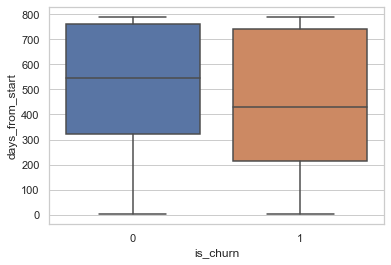

In [20]:
ax = sns.boxplot(x="is_churn", y="days_from_start", data=train_with_features_deduplicated)

### Does churn depend on length of the current subscription?
- This variable needs deeper inversigation.

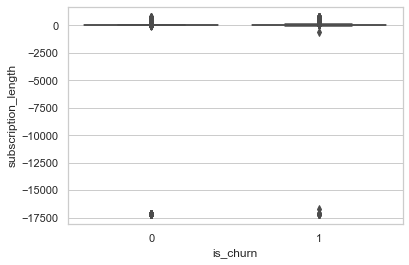

In [26]:
ax = sns.boxplot(x="is_churn", y="subscription_length", 
                 data=train_with_features_deduplicated) #.loc[train_with_features_deduplicated.subscription_length >= 0])

### Does churn depend on number of all transactions that user made?
- Yes, users who churn made a bit less transactions (this is correlated with the first variable)

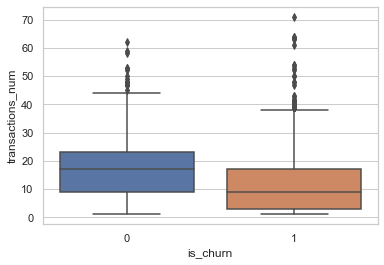

In [28]:
ax = sns.boxplot(x="is_churn", y="transactions_num", data=train_with_features_deduplicated)

### Does churn depend on number of all cancelations that user made?
- Yes, users who churn made more cancelations.

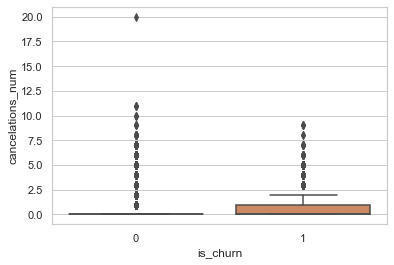

In [29]:
ax = sns.boxplot(x="is_churn", y="cancelations_num", data=train_with_features_deduplicated)

### Does churn depend on the fact if the current subscription is automaticaly renewed?
- Yes, users whose subscripton is automatically renewed churn much less often.

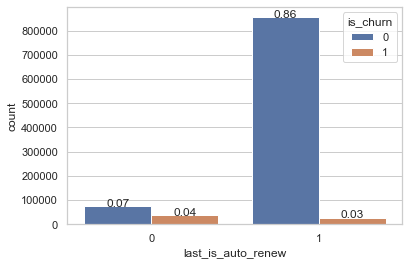

In [44]:
ax = sns.countplot(x="last_is_auto_renew", hue="is_churn", data=train_with_features_deduplicated)
total=train_with_features_deduplicated.shape[0]
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 

In [48]:
print(f"{0.03/0.89: 0.2%} of users whose subscription is automatically renewed churn")
print(f"{0.04/0.11: 0.2%} of users whose subscription is NOT automatically renewed churn")

 3.37% of users whose subscription is automatically renewed churn
 36.36% of users whose subscription is NOT automatically renewed churn


### User logs 
- User logs files are too big to load them into computer memory.
- Reading 1000 first rows we see that they have same columns with numbers of songs listen till 25%, 50%, 75%, 98,5% and 100% of the song length, number of different songs listened and number of seconds listened daily.
- Reading only two columns "msno" and "date" we see that ...

In [8]:
user_logs = pd.read_csv(user_logs_path, nrows=1000) 
user_logs_v2 = pd.read_csv(user_logs_v2_path, nrows=1000)

In [9]:
user_logs

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=,20150513,0,0,0,0,1,1,280.335
1,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=,20150709,9,1,0,0,7,11,1658.948
2,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150105,3,3,0,0,68,36,17364.956
3,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150306,1,0,1,1,97,27,24667.317
4,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150501,3,0,0,0,38,38,9649.029
...,...,...,...,...,...,...,...,...,...
995,GsxqOgdbfqplwVMVVMu/0spt8ysfkSjexZqzyTb5T/E=,20160404,0,0,0,0,4,4,982.000
996,GsxqOgdbfqplwVMVVMu/0spt8ysfkSjexZqzyTb5T/E=,20160623,1,1,1,2,5,10,1993.350
997,GsxqOgdbfqplwVMVVMu/0spt8ysfkSjexZqzyTb5T/E=,20160912,10,3,1,2,5,12,2236.254
998,GsxqOgdbfqplwVMVVMu/0spt8ysfkSjexZqzyTb5T/E=,20161230,5,1,5,0,17,19,5719.019


In [10]:
user_logs_v2

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558
...,...,...,...,...,...,...,...,...,...
995,0wPmoqibk6BFzELAxJ3Q6GcQ1Uwm/iH7jsr/jlWgu7Y=,20170318,0,1,0,0,34,32,8383.520
996,Tlowf5B4ofb2t/J1tqaUNa86z9ExfFOWmuBa+dONDok=,20170319,117,18,9,5,37,124,14768.685
997,VWap+kjstcjQLgPFT1HqfSbk/m4TeXuUxj132H1iMrY=,20170319,3,4,1,2,21,27,5680.734
998,E5vjMhp8WkcWuIzisn49GtTt8J/LKZ3MI0tNhgm8kOw=,20170317,9,5,5,1,13,27,4359.544


In [ ]:
columns_needed = ["msno", "date"]
user_logs = pd.read_csv(user_logs_path,  usecols=columns_needed) 
user_logs_v2 = pd.read_csv(user_logs_v2_path,  usecols=columns_needed)

In [ ]:
user_logs.date.describe()

In [ ]:
user_logs_v2.date.describe()

### Modeling with XGboost
Based on tutorial: **"Using XGBoost in Python"**
<br>
https://www.datacamp.com/community/tutorials/xgboost-in-python?utm_source=adwords_ppc&utm_campaignid=9942305733&utm_adgroupid=100189364546&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034352&utm_targetid=aud-299261629574:dsa-929501846124&utm_loc_interest_ms=&utm_loc_physical_ms=9060640&gclid=Cj0KCQjw0YD4BRD2ARIsAHwmKVkoOKq4tg0ihd-a5jx70ZIDySVNt1e8bTrBYOOQkPIaLb5aElQY3FgaApotEALw_wcB

In [49]:
from sklearn.model_selection import train_test_split
random.seed(1)
train_set, test_set = train_test_split(train_with_features_deduplicated, test_size=0.2)

In [50]:
#XGBoost Model

random.seed(1)
features = ["transactions_num", "cancelations_num", "days_from_start", "last_is_auto_renew", "subscription_length"]
X_train, y_train = train_set[features], train_set["is_churn"]
X_test, y_test = test_set[features], test_set["is_churn"]

xgb_model = xgb.XGBClassifier(verbosity=1,
                              max_depth=4, 
                              learning_rate=0.4,
                              objective= 'binary:logistic',
                              n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.97
Accuracy of XGB classifier on test set: 0.96


### Features importance
- We need to remember that there are many types of feature importance: 'weight', 'gain', 'cover',
- Default: ‘weight’: the number of times a feature is used to split the data across all trees. It may be lower for features with lower cardinality (like True/False features, so our "last_is_auto_renew"),
- ‘gain’: the average gain across all splits the feature is used in.

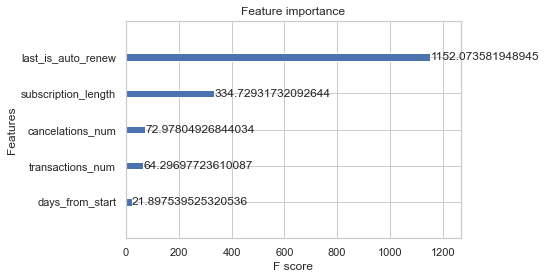

In [51]:
xgb.plot_importance(xgb_model, importance_type="gain")
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

In [240]:
submission = xgb_model.predict_proba(test_with_features_deduplicated[features])

In [241]:
submission_int = xgb_model.predict(test_with_features_deduplicated[features])

In [242]:
pd.DataFrame(submission)

,0,1
0,0.996449,0.003551
1,0.996138,0.003862
2,0.996926,0.003074
3,0.997263,0.002737
4,0.916116,0.083884
...,...,...
907466,0.995891,0.004109
907467,0.996449,0.003551
907468,0.622266,0.377734
907469,0.870872,0.129128


In [245]:
test_with_features_deduplicated.msno.reset_index(drop=True)

0         +++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=
1         +++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=
2         ++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=
3         ++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=
4         ++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=
                              ...                     
907466    zzxZeMFx2fjfKZigMnJa2w0EmloDbm8+8nTf/o/00GY=
907467    zzxi7n5xoTYo9Q3VTygLWvl/rBDcexwaeAry0yK7Q0E=
907468    zzy7iqSpfcRq7R4hmKKuhI+CJRs79a6pteqEggpiNO0=
907469    zzyHq6TK2+cBkeGFUHvh12Z7UxFZiSM7dOOSllSBPDw=
907470    zzzF1KsGfHH3qI6qiSNSXC35UXmVKMVFdxkp7xmDMc0=
Name: msno, Length: 907471, dtype: object

In [243]:
final_submission = pd.DataFrame({"msno": test_with_features_deduplicated.msno.reset_index(drop=True), 
                                 "is_churn": pd.DataFrame(submission).loc[:,1]})

In [246]:
final_submission

,msno,is_churn
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0.003551
1,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0.003862
2,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,0.003074
3,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,0.002737
4,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,0.083884
...,...,...
907466,zzxZeMFx2fjfKZigMnJa2w0EmloDbm8+8nTf/o/00GY=,0.004109
907467,zzxi7n5xoTYo9Q3VTygLWvl/rBDcexwaeAry0yK7Q0E=,0.003551
907468,zzy7iqSpfcRq7R4hmKKuhI+CJRs79a6pteqEggpiNO0=,0.377734
907469,zzyHq6TK2+cBkeGFUHvh12Z7UxFZiSM7dOOSllSBPDw=,0.129128


In [247]:
final_submission.to_csv("submission_4.csv", index=False)